# Building Deep Neural Networks with SAS Viya


### Introduction

The following notebook demonstrates how to build Deep Neural Networks using SAS' deepLearn action set in Visual Data Mining & Machine Learning (VDMML).  The data is from the CFAR-10 dataset, a labeled subset of 80 million tiny images, each 32x32x3. There are 10 classes of images:

<ul>
<li>airplane</li> 
<li>automobile</li>
<li>bird</li>
<li>cat</li>
<li>deer</li>
<li>dog</li>
<li>frog</li>
<li>horse</li>
<li>ship</li>
<li>truck</li>  

The images were collected by Alex Krizhevsky, Vinod 
Nair, and Geoffrey Hinton.  To learn more, visit: https://www.cs.toronto.edu/~kriz/cifar.html

The architecture designed is a DenseNet-12.  The DenseNet paper by Gao Huang, Zhuang Liu, Laurens van der Maaten, and Killian Q. Weinberger can be found here: https://arxiv.org/pdf/1608.06993.pdf

### Import Packages and connect to SAS Viya

In [1]:
import swat
from getpass import *
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix

import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
s = swat.CAS('CAS-Controller-34',5570, username=input("SSO Username:"), password=getpass("SSO Password:"))
s.sessionprop.setsessopt(caslib='CASUSER', timeout=31535000)

SSO Username:sas
SSO Password:········
NOTE: 'CASUSER(sas)' is now the active caslib.


+ Elapsed: 0.0315s, user: 0.0134s, sys: 0.0141s, mem: 1.15mb

### Load the necessary actions from SWAT

In [3]:
s.loadactionset('image')
s.loadactionset('deepLearn')
s.loadactionset('sampling')

NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'sampling'.


[actionset]

 'sampling'

+ Elapsed: 0.013s, user: 0.0104s, sys: 0.0153s, mem: 0.849mb

### Load the CIFAR-10 images into CAS. 

The training images to be loaded into memory are stored in the following location: /opt/sas/sasdata/imagedata.  There are 10 subfolders, one for each category listed above,that are named with the label that is to be attached to each image.  For example, all the bird images live in  /opt/sas/sasdata/imagedata/bird.  CAS will assign the subfolder, bird, as a label to each image in this location to be used as a target in our DNN.

In [4]:
s.image.loadimages(casout={'name':'imagedata', 'blocksize':32,'replace':True, 'compress':False, 'replication':0},   
                   path='imagedata',
                   labellevels=-1,
                   pathislist=False,
                   decode=False,
                   recurse=True)

NOTE: Loaded 50000 images from /home/sas/casuser/imagedata into Cloud Analytic Services table imagedata.


+ Elapsed: 13.4s, user: 9.23s, sys: 23.9s, mem: 64.7mb

### Examine the first 5 rows of the dataset

In [5]:
imagedata=s.CASTable('imagedata')
imagedata.head()

,_image_,_size_,_path_,_label_,_type_,_id_
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,2538,/home/sas/casuser/imagedata/truck/9997.png,truck,png,1
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,2456,/home/sas/casuser/imagedata/truck/9962.png,truck,png,4
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,2404,/home/sas/casuser/imagedata/truck/9948.png,truck,png,7
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,2394,/home/sas/casuser/imagedata/truck/9912.png,truck,png,10
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,2143,/home/sas/casuser/imagedata/truck/9887.png,truck,png,13


### Shuffle the data into a random order and partition into train and test

In [6]:
s.table.shuffle(table={'name':'imagedata'}, casout={'name':'imagedatashuffle', 'replace':True})

[caslib]

 'CASUSER(sas)'

[tableName]

 'IMAGEDATASHUFFLE'

[casTable]

 CASTable('IMAGEDATASHUFFLE', caslib='CASUSER(sas)')

+ Elapsed: 0.376s, user: 0.334s, sys: 1.1s, mem: 172mb

### Partition into train and test

In [7]:
s.sampling.srs(table={'name':'imagedatashuffle'},
               seed=1985,
               samppct=95,
               partind=True,
               output={'casOut':{'name':'imagedatapart', 'replace':True, 'replication':'0', 
                                'compress':False},'copyVars':'ALL'})

NOTE: Using SEED=1985 for sampling.


[outputSize]

 {'outputNObs': 50000.0, 'outputNVars': 7}

[SRSFreq]

 Frequencies
 
     NObs  NSamp
 0  50000  47500

[OutputCasTables]

          casLib           Name Label   Rows  Columns  \
 0  CASUSER(sas)  imagedatapart        50000        7   
 
                                            casTable  
 0  CASTable('imagedatapart', caslib='CASUSER(sas)')  

+ Elapsed: 0.13s, user: 0.164s, sys: 0.358s, mem: 189mb

### Summarize images in the train dataset

In [8]:
s.image.summarizeImages(table={'name':'imagedatapart','where':'_PartInd_=1'})

NOTE: Table IMAGEDATAPART contains compressed images.
NOTE: 47500 out of 47500 images were scanned and results were saved to the summary table.


,Column,png,minWidth,maxWidth,minHeight,maxHeight,meanWidth,meanHeight,mean1stChannel,min1stChannel,max1stChannel,mean2ndChannel,min2ndChannel,max2ndChannel,mean3rdChannel,min3rdChannel,max3rdChannel
0,_image_,47500.0,32.0,32.0,32.0,32.0,32.0,32.0,113.952043,0.0,255.0,122.989499,0.0,255.0,125.32385,0.0,255.0


### Summarize images in the test dataset


In [9]:
s.image.summarizeImages(table={'name':'imagedatapart','where':'_PartInd_=0'})

NOTE: Table IMAGEDATAPART contains compressed images.
NOTE: 2500 out of 2500 images were scanned and results were saved to the summary table.


,Column,png,minWidth,maxWidth,minHeight,maxHeight,meanWidth,meanHeight,mean1stChannel,min1stChannel,max1stChannel,mean2ndChannel,min2ndChannel,max2ndChannel,mean3rdChannel,min3rdChannel,max3rdChannel
0,_image_,2500.0,32.0,32.0,32.0,32.0,32.0,32.0,112.218853,0.0,255.0,122.207401,0.0,255.0,124.985211,0.0,255.0


### Examine the first five rows of the shuffled dataset

In [10]:
imagedatapart_py=s.CASTable('imagedatapart')
imagedatapart_py.head()

,_image_,_size_,_path_,_label_,_type_,_id_,_PartInd_
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,2337,/home/sas/casuser/imagedata/airplane/46899.png,airplane,png,45907,1.0
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,2374,/home/sas/casuser/imagedata/airplane/47764.png,airplane,png,45799,1.0
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,2140,/home/sas/casuser/imagedata/ship/38010.png,ship,png,6932,1.0
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,2585,/home/sas/casuser/imagedata/frog/10719.png,frog,png,19914,1.0
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,2272,/home/sas/casuser/imagedata/deer/3409.png,deer,png,27290,1.0


### Display five images and their labels

In [11]:
CIFARImages=s.image.fetchImages(table='imagedatapart', to=5, fetchVars={'labels'})

NOTE: Table IMAGEDATAPART contains compressed images.


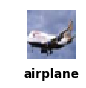

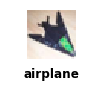

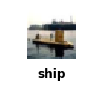

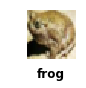

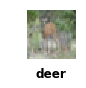

In [12]:
for i in range(5):
  plt.figure(figsize = (.9,.9))
  plt.axis('off')
  plt.imshow(CIFARImages.Images.Image[i])
  plt.title(imagedatapart_py.head().values[i][3], fontweight='bold',y=-.5)
  plt.show()

### Remove datasets from memory that are no longer in use

In [13]:
s.table.dropTable(name='imagedata')

NOTE: Cloud Analytic Services dropped table imagedata from caslib CASUSER(sas).


+ Elapsed: 0.0525s, user: 0.0512s, sys: 0.0219s, mem: 1.08mb

### Build a DenseNet-12 Neural Network

We will use five actions from CAS' deepLearn actionset to build, train, and score a Convolution Neural network :
<ol>
<li>buildModel:  Creates an empty deep learning model.  The table output from this is where DNN layers and model type are specified (example: CNN)</li>
<li>addLayer: Adds a layer, such as a convolution layer, pooling layer, or a fully connected layer to the network architecture</li>
<li>dlTrain: Trains the DNN model and estimates the parameter weights </li>
<li>dlScore: Applies the model logic to a dataset and provides a list of scores as outputs </li>
<li>dlExportModel: Allows the model to be exported and deployed on other platforms for scoring </li>
</ol>

<img src="https://raw.githubusercontent.com/jessebehrens/SASExamples/master/Viya/DeepNeuralNetworks/data/DenseNetDiagram.JPG" alt="DenseNet-12">

### Build Model

In [14]:
s.deepLearn.buildModel(modelTable={'name':'DenseNet12','replace':True}, type='CNN')

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,1,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


### Add Layers 

#### Input Layer

In [15]:
s.deepLearn.addLayer(modelTable={'name':'DenseNet12'}, 
                     name='InputImageData',  
                     layer={'type':'input', 'nchannels':3, 'width':32, 'height':32, 'offsets':[114,122,125]})

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,14,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


#### Convolutional Layer

In [16]:
s.deepLearn.addLayer(modelTable={'name':'DenseNet12'},
                     name='Conv0',
                     layer={'type':'convo', 'nFilters':16, 'width':3, 'height':3, 'stride':1,
                            'act':'identity', 'nobias':True, 'init':'xavier'},
                     srcLayers=['InputImageData'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,34,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


#### Dense Block 1

<img src="https://raw.githubusercontent.com/jessebehrens/SASExamples/master/Viya/DeepNeuralNetworks/data/DenseBlock.JPG" alt="Dense Block">

In [17]:
s.deepLearn.addLayer(modelTable={'name':'DenseNet12'},
                     name='BN1_1',
                     layer={'type':'batchnorm', 'act':'relu'}, 
                     srcLayers=['Conv0'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,37,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [18]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='Conv1_1',
                     layer={'type':'convo', 'nFilters':12, 'width':3, 'height':3, 'stride':1,
                            'act':'relu', 'nobias':True, 'init':'xavier', 'dropout':0.2}, 
                     srcLayers=['bn1_1'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,57,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [19]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='concat1_1',
                     layer={'type':'concat'},
                     srcLayers=['Conv0','Conv1_1'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,62,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [20]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='BN1_2',
                     layer={'type':'batchnorm', 'act':'relu'},
                     srcLayers=['concat1_1'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,65,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [21]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='conv1_2',
                     layer={'type':'convo', 'nFilters':12, 'width':3, 'height':3, 'stride':1,
                            'act':'relu', 'nobias':True, 'init':'xavier', 'dropout':0.2},
                     srcLayers=['BN1_2'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,85,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [22]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='concat1_2',
                     layer={'type':'concat'},
                     srcLayers=['conv0','conv1_1','conv1_2'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,91,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [23]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='BN1_3',
                     layer={'type':'batchnorm','act':'relu'},
                     srcLayers=['concat1_2'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,94,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


#### Transition Layer 1

<img src="https://raw.githubusercontent.com/jessebehrens/SASExamples/master/Viya/DeepNeuralNetworks/data/TransitionLayer.JPG" alt="Transition Layer">

In [24]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='conv1_3',
                     layer={'type':'convo','nFilters':40, 'width':3, 'height':3, 'stride':1,
                            'act':'relu', 'nobias':True, 'init':'xavier', 'dropout':0.2},
                     srcLayers=['bn1_3'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,114,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [25]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='pool1',
                     layer={'type':'pooling','width':2, 'height':2, 'pool':'mean'},
                     srcLayers=['conv1_3'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,127,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


#### Dense Block 2

In [26]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='BN2_1',
                     layer={'type':'batchnorm', 'act':'relu'},
                     srcLayers=['pool1'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,130,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [27]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='conv2_1',
                     layer={'type':'convo', 'nFilters':12, 'width':3, 'height':3, 'stride':1,
                            'act':'relu', 'nobias':True, 'init':'xavier', 'dropout':0.2},
                     srcLayers=['bn2_1'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,150,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [28]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='concat2_1',
                     layer={'type':'concat'},
                     srcLayers=['conv2_1','pool1'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,155,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [29]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='BN2_2',
                     layer={'type':'batchnorm', 'act':'relu'},
                     srcLayers=['concat2_1'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,158,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [30]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='conv2_2',
                     layer={'type':'convo', 'nFilters':12, 'width':3, 'height':3, 'stride':1,
                            'act':'relu', 'nobias':True, 'init':'xavier', 'dropout':0.2},
                     srcLayers=['bn2_2'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,178,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [31]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='concat2_2',
                     layer={'type':'concat'},
                     srcLayers=['conv2_2','conv2_1','pool1'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,184,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


#### Transition Layer 2

In [32]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='BN2_3',
                     layer={'type':'batchnorm', 'act':'relu'},
                     srcLayers=['concat2_2'])


,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,187,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [33]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='conv2_3',
                     layer={'type':'convo', 'nFilters':64, 'width':3, 'height':3, 'stride':1,
                            'act':'relu', 'nobias':True, 'init':'xavier', 'dropout':0.2},
                     srcLayers=['bn2_3'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,207,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [34]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='pool2',
                     layer={'type':'pooling','width':2, 'height':2, 'pool':'mean'},
                     srcLayers=['conv2_3'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,220,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


#### Dense Block 3

In [35]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='BN3_1',
                     layer={'type':'batchnorm', 'act':'relu'},
                     srcLayers=['pool2'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,223,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [36]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='conv3_1',
                     layer={'type':'convo', 'nFilters':12, 'width':3, 'height':3, 'stride':1,
                            'act':'relu', 'nobias':True, 'init':'xavier', 'dropout':0.2},
                     srcLayers=['bn3_1'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,243,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [37]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='concat3_1',
                     layer={'type':'concat'},
                     srcLayers=['conv3_1','pool2'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,248,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [38]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='BN3_2',
                     layer={'type':'batchnorm', 'act':'relu'},
                     srcLayers=['concat3_1'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,251,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [39]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='conv3_2',
                     layer={'type':'convo', 'nFilters':12, 'width':3, 'height':3, 'stride':1,
                            'act':'relu', 'nobias':True, 'init':'xavier', 'dropout':0.2},
                     srcLayers=['bn3_2'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,271,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [40]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='concat3_2',
                     layer={'type':'concat'},
                     srcLayers=['conv3_2', 'conv3_1','pool2'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,277,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [41]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='BN3_3',
                     layer={'type':'batchnorm', 'act':'relu'},
                     srcLayers=['concat3_2'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,280,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [42]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='conv3_3',
                     layer={'type':'convo', 'nFilters':88, 'width':3, 'height':3, 'stride':1,
                            'act':'relu', 'nobias':True, 'init':'xavier', 'dropout':0.2},
                     srcLayers=['bn3_3'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,300,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


####  Classification Layer

In [43]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='pool3',
                     layer={'type':'pooling','width':7, 'height':7, 'stride':7, 'pool':'mean'},
                     srcLayers=['conv3_3'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,313,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


In [44]:
s.deepLearn.addLayer(modeltable={'name':'DenseNet12'},
                     name='output',
                     layer={'type':'output', 'act':'softmax', 'init':'xavier'},
                     srcLayers=['pool3'])

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sas),densenet12,326,5,"CASTable('densenet12', caslib='CASUSER(sas)')"


### Train the Model

In [45]:
DNN=s.deepLearn.dlTrain(modeltable={'name':'DenseNet12'},
                        inputs=['_image_'],
                        target='_label_',
                        targetOrder='ascending',
                        modelweights={'name':'DenseNetWeights','replace':True},
                        optimizer={'algorithm':{'method':'momentum','learningRate':0.01, 'stepsize':30,
                                                'lrpolicy':'step','clipgradmin':-1000, 'clipgradmax':1000},
                                   'maxEpochs':256,
                                   'loglevel':2,
                                   'minibatchsize':1,
                                   'regL2':0.0005},         
                        table={'name':'imagedatapart','where':'_PartInd_=1'})

NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 155666.
NOTE:  The approximate memory cost is 54.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.11 (s).
NOTE:  The total number of workers is 3.
NOTE:  The total number of threads on each worker is 8.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 24.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:     10
NOTE:  Levels for the target variable:
NOTE:  Level      0: airplane  
NOTE:  Level      1: automobile
NOTE:  Level      2: bird      
NOTE:  Level      3: cat       
NOTE:  Level      4: deer      
NOTE:  Level      5: dog       
NOTE:  Level      6: frog      
NOTE:  Level      7: horse     
NOTE:  Level      8: ship      
NOTE:  Level      9: truck     
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input v

NOTE:        102            1E-5       0.1513     0.0495       262.55
NOTE:        103            1E-5       0.1506     0.0504       261.42
NOTE:        104            1E-5       0.1488     0.0491       263.19
NOTE:        105            1E-5        0.151     0.0496       263.32
NOTE:        106            1E-5       0.1476     0.0488       263.62
NOTE:        107            1E-5       0.1523     0.0503       264.39
NOTE:        108            1E-5       0.1462     0.0474       263.83
NOTE:        109            1E-5       0.1511     0.0503       262.33
NOTE:        110            1E-5       0.1503     0.0497       262.18
NOTE:        111            1E-5       0.1484     0.0492       265.36
NOTE:        112            1E-5       0.1484     0.0494       263.16
NOTE:        113            1E-5       0.1497     0.0485       265.52
NOTE:        114            1E-5       0.1482     0.0489       262.87
NOTE:        115            1E-5       0.1485     0.0495       262.82
NOTE:        116    

NOTE:        220            1E-9        0.146     0.0476       265.86
NOTE:        221            1E-9       0.1467     0.0484       266.39
NOTE:        222            1E-9       0.1482     0.0484       265.98
NOTE:        223            1E-9       0.1479     0.0496       264.44
NOTE:        224            1E-9       0.1484     0.0495       265.17
NOTE:        225            1E-9       0.1481     0.0496       266.67
NOTE:        226            1E-9       0.1471     0.0478       266.47
NOTE:        227            1E-9       0.1492     0.0495       264.65
NOTE:        228            1E-9       0.1475      0.049       264.86
NOTE:        229            1E-9       0.1476     0.0487       261.66
NOTE:        230            1E-9        0.146     0.0488       265.22
NOTE:        231            1E-9       0.1477     0.0493       263.73
NOTE:        232            1E-9       0.1497      0.049       263.24
NOTE:        233            1E-9       0.1442     0.0464       266.67
NOTE:        234    

In [46]:
DNN

,Descr,Value
0,Model Name,densenet12
1,Model Type,Convolutional Neural Network
2,Number of Layers,30
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,10
6,Number of Pooling Layers,3
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,9
9,Number of Concat Layers,6


In [47]:
target_dict=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

### Score the model on the train dataset

Scoring the training dataset will provide more model metrics

In [48]:
s.deepLearn.dlScore(modeltable={'name':'DenseNet12'},
                    initWeights={'name':'DenseNetWeights'},
                    table={'name':'imagedatapart','where':'_PartInd_=1'},
                    casout={'name':'densenetscored', 'replace':True})

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read         47500
 1  Number of Observations Used         47500
 2  Misclassification Error (%)          2.24
 3                   Loss Error      0.076326

[OutputCasTables]

          casLib            Name   Rows  Columns  \
 0  CASUSER(sas)  densenetscored  47500       13   
 
                                             casTable  
 0  CASTable('densenetscored', caslib='CASUSER(sas)')  

+ Elapsed: 16.7s, user: 268s, sys: 0.0839s, mem: 466mb

### Score the model on the holdout sample

Score the holdout sample to understand what parameters to tune.

In [49]:
s.deepLearn.dlScore(modeltable={'name':'DenseNet12'},
                    initWeights={'name':'DenseNetWeights'},
                    table={'name':'imagedatapart','where':'_PartInd_=0'},
                    casout={'name':'densenetscored', 'replace':True})

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          2500
 1  Number of Observations Used          2500
 2  Misclassification Error (%)          12.8
 3                   Loss Error      0.381552

[OutputCasTables]

          casLib            Name  Rows  Columns  \
 0  CASUSER(sas)  densenetscored  2500       13   
 
                                             casTable  
 0  CASTable('densenetscored', caslib='CASUSER(sas)')  

+ Elapsed: 1.06s, user: 14.4s, sys: 0.0425s, mem: 461mb

### Export the model as an astore file

Astore files are binary files that allow models to be deployed and score on a variety of systems such as databases or SAS platforms.

In [50]:
s.deepLearn.dlExportModel(modeltable={'name':'DenseNet12'},
                          initWeights={'name':'DenseNetWeights'},
                          casout={'name':'DenseNetExport', 'replace':True})

NOTE: Wrote 643295 bytes to the savestate file DenseNetExport.


,casLib,Name
0,CASUSER(sas),DenseNetExport


### Import the test image data

In [51]:
s.image.loadimages(casout={'name':'testimagedata', 'blocksize':32,'replace':True, 'compress':False, 'replication':0},   
                   path='testimagedata',
                   labellevels=-1,
                   pathislist=False,
                   decode=False,
                   recurse=True)

NOTE: Loaded 10000 images from /home/sas/casuser/testimagedata into Cloud Analytic Services table testimagedata.


+ Elapsed: 2.35s, user: 4.19s, sys: 2.21s, mem: 36.5mb

In [52]:
s.image.summarizeImages(table={'name':'testimagedata'})

NOTE: Table TESTIMAGEDATA contains compressed images.
NOTE: 10000 out of 10000 images were scanned and results were saved to the summary table.


,Column,png,minWidth,maxWidth,minHeight,maxHeight,meanWidth,meanHeight,mean1stChannel,min1stChannel,max1stChannel,mean2ndChannel,min2ndChannel,max2ndChannel,mean3rdChannel,min3rdChannel,max3rdChannel
0,_image_,10000.0,32.0,32.0,32.0,32.0,32.0,32.0,114.854319,0.0,255.0,123.708504,0.0,255.0,126.024641,0.0,255.0


### Using the astore to score a test dataset

In [53]:
s.loadactionset('aStore')
s.aStore.score(table={'name':'testimagedata'},
               out={'name':'testimagedatascored', 'replace':True},
               copyVars='_label_',
               rstore={'name':'DenseNetExport'})

NOTE: Added action set 'aStore'.


[OutputCasTables]

          casLib                 Name   Rows  Columns  \
 0  CASUSER(sas)  testimagedatascored  10000       12   
 
                                             casTable  
 0  CASTable('testimagedatascored', caslib='CASUSE...  

[Timing]

 Task Timing
 
                  Task   Seconds   Percent
 0   Loading the Store  0.005936  0.001967
 1  Creating the State  0.157233  0.052103
 2             Scoring  2.854569  0.945929
 3               Total  3.017742  1.000000

+ Elapsed: 3.04s, user: 65.6s, sys: 0.136s, mem: 483mb

In [54]:
testimagedatascored=s.CASTable('testimagedatascored')
testimagedatascored.head()

,P__label_airplane,P__label_automobile,P__label_bird,P__label_cat,P__label_deer,P__label_dog,P__label_frog,P__label_horse,P__label_ship,P__label_truck,I__label_,_label_
0,4.806139e-20,4.525878e-11,2.224239e-24,3.285176e-20,6.445164e-24,3.850599e-22,6.902377e-22,9.954796e-21,1.838629e-15,1.000000,truck,truck
1,7.802360e-11,8.654297e-08,2.700329e-15,5.809285e-13,1.263242e-14,7.630046e-13,3.408568e-10,7.530924e-12,3.401990e-09,1.000000,truck,truck
2,3.988292e-13,1.545916e-06,8.872672e-19,4.898405e-11,5.933794e-17,1.500556e-13,8.206401e-14,6.838711e-13,2.942770e-12,0.999998,truck,truck
3,3.154288e-03,5.305231e-02,8.135483e-05,1.465825e-02,2.568068e-04,2.332593e-03,2.482877e-05,1.030854e-03,3.182500e-05,0.925377,truck,truck
4,2.818755e-04,1.208750e-04,2.529303e-09,3.858524e-08,1.541565e-08,4.848574e-10,3.147214e-10,1.270066e-07,1.745201e-04,0.999423,truck,truck


### Bring the resulting table back to use pyplot on

Bring the test results back and use scikit learn to plot a confusion matrix of the results.  The orginal confusion matrix code is provided here: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [55]:
testimagedatascored_py=testimagedatascored.to_frame()

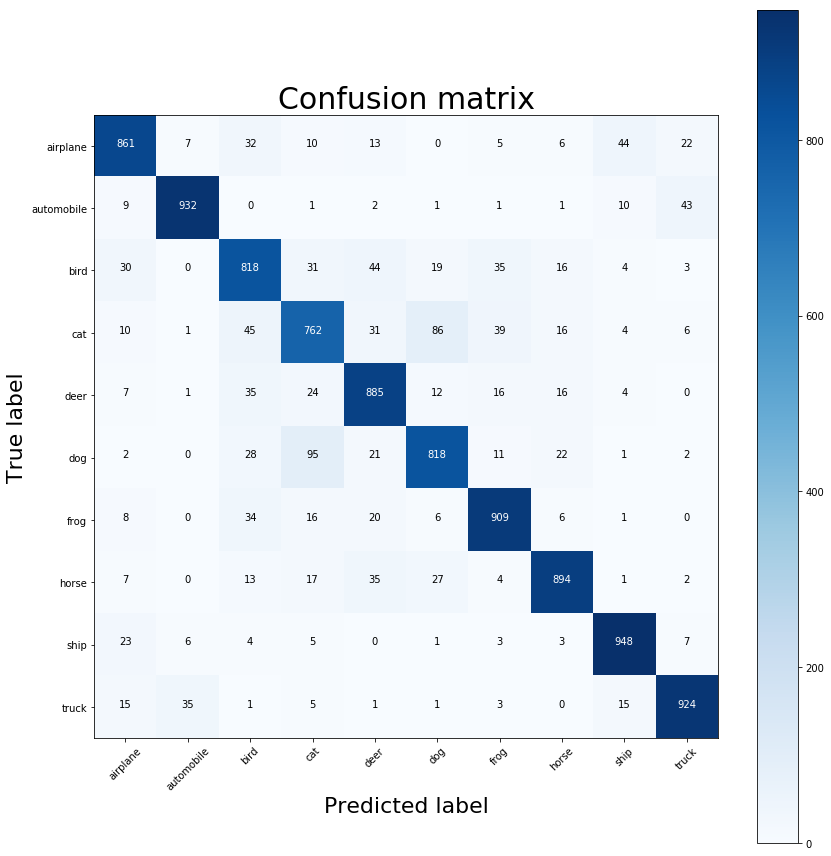

In [56]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(target_dict))
    plt.xticks(tick_marks, target_dict, rotation=45)
    plt.yticks(tick_marks, target_dict)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=22)
    plt.xlabel('Predicted label',fontsize=22)

# Compute confusion matrix
cnf_matrix = confusion_matrix(testimagedatascored_py['_label_'], testimagedatascored_py['I__label_'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')
plt.show()

# Is it "Machine Learning" or Machine Training?

We've built a DenseNet-12 CNN.  To demonstrate the limits of 'machine learning,' we will feed the model three new images the model has never seen. <ol><li>Hotdogs</li> <li>Bill Murray</li> <li>The Stanley Cup</li><li>A Last Name</li></ol>

Let's see how "machine learning" classifies these three images

### Import the three data images without labels

In [57]:
s.image.loadimages(casout={'name':'machinelearning', 'replace':True, 'compress':False, 'replication':0},   
                   path='mlimages')

NOTE: Loaded 4 images from /home/sas/casuser/mlimages into Cloud Analytic Services table machinelearning.


+ Elapsed: 0.0527s, user: 0.141s, mem: 17.6mb

In [58]:
s.image.summarizeImages(table={'name':'machinelearning'})

NOTE: Table MACHINELEARNING contains compressed images.
NOTE: 4 out of 4 images were scanned and results were saved to the summary table.


,Column,jpg,minWidth,maxWidth,minHeight,maxHeight,meanWidth,meanHeight,mean1stChannel,min1stChannel,max1stChannel,mean2ndChannel,min2ndChannel,max2ndChannel,mean3rdChannel,min3rdChannel,max3rdChannel
0,_image_,4.0,158.0,2447.0,70.0,2193.0,1032.75,1017.5,132.695422,0.0,255.0,142.928992,0.0,255.0,152.55214,0.0,255.0


In [59]:
MLImages=s.image.fetchImages(table='machinelearning')

NOTE: Table MACHINELEARNING contains compressed images.


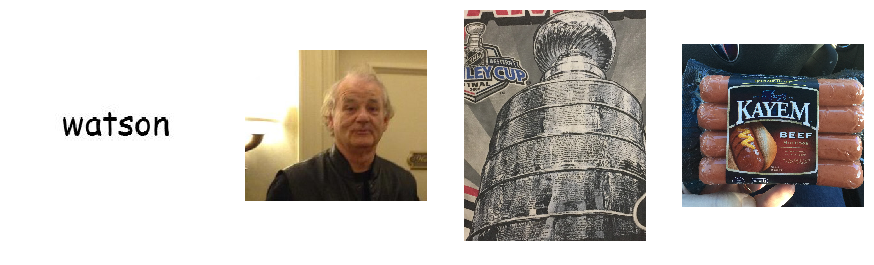

In [60]:
f, axarr = plt.subplots(1,4,figsize=(15,15))

axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[3].axis('off')
axarr[0].imshow(MLImages.Images.Image[0])
axarr[1].imshow(MLImages.Images.Image[1])
axarr[2].imshow(MLImages.Images.Image[2])
axarr[3].imshow(MLImages.Images.Image[3]);

### Resize the images to 32x32 for the DenseNet

In [61]:
s.image.processImages(imageTable={'name':'machinelearning'},
                      imageFunctions=[{'functionOptions':{'functionType':'RESIZE','h':32,'w':32}}],              
                      casOut={'name':'MLresized','replace':True})

NOTE: Table MACHINELEARNING contains compressed images.
NOTE: 4 out of 4 images were processed successfully and saved as compressed images to the Cloud Analytic Services table MLresized.


+ Elapsed: 0.124s, user: 0.202s, mem: 53.8mb

In [62]:
MLResizedImages=s.image.fetchImages(table='MLresized')

NOTE: Table MLRESIZED contains compressed images.


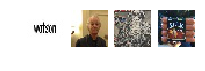

In [63]:
f, axarr = plt.subplots(1,4,figsize=(3,4))

axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[3].axis('off')
axarr[0].imshow(MLResizedImages.Images.Image[0])
axarr[1].imshow(MLResizedImages.Images.Image[1])
axarr[2].imshow(MLResizedImages.Images.Image[2])
axarr[3].imshow(MLResizedImages.Images.Image[3]);

### Score the three images using our aStore file to see how a DenseNet12 will classify them.

In [64]:
s.aStore.score(table={'name':'MLresized'},
               out={'name':'MLResizedscored', 'replace':True},
               copyVars='_path_',
               rstore={'name':'DenseNetExport'})

[OutputCasTables]

          casLib             Name  Rows  Columns  \
 0  CASUSER(sas)  MLResizedscored     4       12   
 
                                             casTable  
 0  CASTable('MLResizedscored', caslib='CASUSER(sa...  

[Timing]

 Task Timing
 
                  Task   Seconds   Percent
 0   Loading the Store  0.006039  0.035837
 1  Creating the State  0.144236  0.855945
 2             Scoring  0.018233  0.108204
 3               Total  0.168510  1.000000

+ Elapsed: 0.194s, user: 0.565s, sys: 0.0884s, mem: 482mb

In [65]:
s.CASTable('MLResizedscored')[['_path_','I__label_']].head()

,_path_,I__label_
0,/home/sas/casuser/mlimages/word.JPG,airplane
1,/home/sas/casuser/mlimages/BillMurray.jpg,cat
2,/home/sas/casuser/mlimages/StanleyCup.JPG,frog
3,/home/sas/casuser/mlimages/hotdog.JPG,truck


We gave our machine very common objects; however, it was not able to classify it to anything outside of what we have trained it to do.  I believe this demonstrates how 'Machine Learning' is still a buzzword.  Any great problem requires a great analyst behind it!!

### Sign out of CAS

In [66]:
s.session.endsession()

+ Elapsed: 0.00704s, user: 0.0109s, mem: 0.834mb